In [1]:
import os
import numpy as np
import pandas as pd

import pymatgen as pg


In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

In [3]:

def local_min(df):

    df['dy'] = df['Edis'].diff()

    df['sign_dy'] = np.sign(df['dy'])
    df['sign_change'] = df['sign_dy'].diff()

    # Indices of local maxima: derivative goes from negative (-1) to positive (+1)
    local_min_indices = df.index[(df['sign_change'] > 0)]

    if len(local_min_indices) == 0:
        print('No local max found')
        new_df = pd.DataFrame(columns=['cell_length', 'Edis'])
        # put values 0 , 0 in the dataframe
        new_df.loc[0] = [0, 0]
        print(min(new_df['Edis']))
        return new_df
    local_mins = df.loc[local_min_indices, ['cell_length', 'Edis']].reset_index(drop=True)

    return local_mins

def local_max(df):
    df['dy'] = df['Edis'].diff()

    df['sign_dy'] = np.sign(df['dy'])
    df['sign_change'] = df['sign_dy'].diff()
    
    # Indices of local maxima: derivative goes from negative (-1) to positive (+1)
    local_min_indices = df.index[(df['sign_change'] < 0)]

    if len(local_min_indices) == 0:
        print('No local max found')
        new_df = pd.DataFrame(columns=['cell_length', 'Edis'])
        # put values 0 , 0 in the dataframe
        new_df.loc[0] = [0, 0]
        print(min(new_df['Edis']))
        return new_df

    local_max = df.loc[local_min_indices, ['cell_length', 'Edis']].reset_index(drop=True)
    return local_max

In [4]:
def finding_diff(df):
    abs_max = df['Edis'].iloc[-1]
    max_val = max(local_max(df)['Edis'])
    min_val = min(local_min(df)['Edis'])
    min_val_idx = local_min(df)[local_min(df)['Edis'] == min_val].index[0]
    min_length = local_min(df).loc[min_val_idx, 'cell_length']
    
    max_val_idx = local_max(df)[local_max(df)['Edis'] == max_val].index[0]
    
    # equation of line between two points (x1, y1) and (x2, y2)
    x1 = local_max(df).loc[max_val_idx, 'cell_length'] 
    x2 = df['cell_length'].iloc[-1]

    y1 = max_val
    y2 = abs_max
    # print(min_length)
    
    # Finding the maximum slope
    max_slope = float('-inf')
    best_x2 = x2
    best_y2 = y2
    
    # Get the dataframe points after x1
    points_after_x1 = df[df['cell_length'] > x1][['cell_length', 'Edis']]
    
    # Iterate through all points after x1
    for idx, row in points_after_x1.iterrows():
        temp_x2 = row['cell_length']
        temp_y2 = row['Edis']
        temp_slope = (y1 - temp_y2) / (x1 - temp_x2)
        
        if temp_slope > max_slope:
            max_slope = temp_slope
            best_x2 = temp_x2
            best_y2 = temp_y2
    
    x2 = best_x2
    y2 = best_y2
    slope = max_slope
    intercept = y2 - slope * x2

    if y2 < y1:
        slope = 0
        intercept = y1

    #value of y when x = min_length
    y_at_min_length = slope * min_length + intercept

    diff = abs(min_val - y_at_min_length)
    return diff


In [5]:
from pymatgen.core import Structure

In [6]:
#list all folders inside li_d3s
li_d3s = os.listdir("li_d3s")

results = []

df = pd.DataFrame()
cnt=0
for items in li_d3s:
    cnt+=1
    #get the path of each folder
    path = os.path.join("li_d3s", items)
    # print(items)
    
    #ignore .DS_Store
    if items == ".DS_Store":
        continue
    file = os.path.join(path, f'{items}.csv')
    struct_file = os.path.join(path, 'POSCAR')
    df = pd.read_csv(file)
    print(f"Reading {file}")
    # exract materials id from file name

    material_id = os.path.basename(file).split('.')[0].split('_')[1]
    print(f"Material ID: mp-{material_id}")
    struct = Structure.from_file(struct_file)
    sites = struct.num_sites
    
    # print(struct.composition['Li'])
    li_sites = struct.composition['Li']
    counter_ion_sites = struct.composition[struct.composition.elements[1]]
    diff_energy = finding_diff(df)
    print(f'Composition {struct.composition}')
    print(f'diff per toal sites {diff_energy/sites}')
    print(f'diff per cation sites {diff_energy/li_sites}')
    print('-----------------------------------')

    result = {
        "Symbol": struct.composition.elements[0] if struct.composition.elements[0].symbol != 'Li' else struct.composition.elements[1],
        "Structure": struct.composition,
        "Total Sites": sites,
        "Cation Sites": li_sites,
        "Counter Ion Sites": counter_ion_sites,
        "Diff Energy": diff_energy,
        "Diff per Total Sites": diff_energy/sites,
        "Diff per Cation Sites": diff_energy/li_sites,
        "Diff per Counter Ion Sites": diff_energy/counter_ion_sites,
        "Volume": struct.volume,
        "mid": material_id,
        "Composition": str(struct.composition)
    }

    results.append(result)
print(f'total structure analysed = {cnt}')
    

Reading li_d3s/LiGa3_1185332/LiGa3_1185332.csv
Material ID: mp-1185332
Composition Li1 Ga3
diff per toal sites 0.009796941276506857
diff per cation sites 0.03918776510602743
-----------------------------------
Reading li_d3s/LiCu3_1185338/LiCu3_1185338.csv
Material ID: mp-1185338
Composition Li2 Cu6
diff per toal sites 0.011480842426287387
diff per cation sites 0.04592336970514955
-----------------------------------
Reading li_d3s/LiAg_2426/LiAg_2426.csv
Material ID: mp-2426
Composition Li1 Ag1
diff per toal sites 0.009966383238525788
diff per cation sites 0.019932766477051576
-----------------------------------
Reading li_d3s/Li3Pd_11489/Li3Pd_11489.csv
Material ID: mp-11489
Composition Li3 Pd1
diff per toal sites 0.014731717825714266
diff per cation sites 0.019642290434285687
-----------------------------------
Reading li_d3s/Li3In_976055/Li3In_976055.csv
Material ID: mp-976055
Composition Li3 In1
diff per toal sites 0.01616699929574364
diff per cation sites 0.02155599906099152
-----

### for individual elements

In [7]:
results_df = pd.DataFrame(results)
results_df.to_csv("analysis_results.csv", index=False)

print(f"Total structures analysed = {cnt}")
# print("Results saved to analysis_results.csv")

results_df['Diff per Total Sites'].max()*1000

Total structures analysed = 452


31.246237249043702

### Thougest part is to make the Feature functions data 


In [8]:
props = pd.read_csv('../mixed_comps/PubChemElements_all.csv')
polarisability = pd.read_csv('../elements_polarizability.csv')

props = props[['Symbol', 'AtomicMass','AtomicRadius','Electronegativity','IonizationEnergy','ElectronAffinity']]

In [9]:
all_props = []
cnt = 0
for items in li_d3s:
    # cnt+=1
    #get the path of each folder
    path = os.path.join("li_d3s", items)
    # print(items)
    
    #ignore .DS_Store
    if items == ".DS_Store":
        continue
    file = os.path.join(path, f'{items}.csv')
    struct_file = os.path.join(path, 'POSCAR')


    struct = Structure.from_file(struct_file)
    sites = struct.num_sites

    vol_site = struct.volume/sites
    # print(density)

    # print(struct.composition.elements[1])

    elem = struct.composition.elements[0] if(struct.composition.elements[1].symbol == 'Li')  else struct.composition.elements[1]

    print(elem)
    # print(elem.symbol == 'Ge')

    matched_row = props[props['Symbol'] == elem.symbol]
    elem_polarizability = polarisability[polarisability['Symbol'] == elem.symbol]

    space_group = struct.get_space_group_info()


    
    print(struct.composition.reduced_formula)
    # DiffPerLi = results_df[results_df['Symbol'] == elem.symbol]
    # matched_row.add('Polarizability', elem_polarizability['Polarizability'].values[0])
    matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
    matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
    matched_row['results_per_cation'] = results_df['Diff per Cation Sites'][cnt]*1000
    # matched_row['TotalSites'] = results_df['Total Sites'][cnt]
    matched_row['CationSites'] = results_df['Cation Sites'][cnt]/sites
    matched_row['CounterIonSites'] = results_df['Counter Ion Sites'][cnt]/sites
    matched_row['results_per_counter_ion'] = results_df['Diff per Counter Ion Sites'][cnt]
    # matched_row['Diff per Li Sites'] = DiffPerLi['Diff per Li Sites'].values[0]
    matched_row['res_per_volm_per_site'] = results_df['Diff per Total Sites'][cnt]/vol_site
    matched_row['Result']=  results_df['Diff per Total Sites'][cnt]/vol_site*1000
    matched_row['SpaceGroup'] = space_group[0]
    matched_row['SpaceGroupNumber'] = space_group[1]
    matched_row['Total Sites'] = sites
    matched_row['Volume'] = results_df['Volume'][cnt]
    matched_row['mid'] = results_df['mid'][cnt]
    matched_row["Reduced Formula"] = struct.composition.reduced_formula
    all_props.append(matched_row)

    cnt+=1

all_props_df = pd.concat(all_props, ignore_index=True)
    

Ga
LiGa3
Cu
LiCu3
Ag
LiAg
Pd
Li3Pd
In
Li3In
Pr
LiPr3
Mg
LiMg
Ce
LiCe3
Sb
Li27Sb10
Cd
Li2Cd
Al
Li3Al2
P
Li3P
Na
NaLi3
Al
Li2Al
S
Li2S
Mg
LiMg3
Tc
Li3Tc
Ca
Li3Ca
In
LiIn3
Si
Li7Si2
Rb
Rb3Li
K
K3Li
Pb
Li10Pb3
C
Li3C
Rb
Rb3Li
C
LiC12
Sn
Li5Sn2
Lu
LiLu3
Ca
Li2Ca
Mg
LiMg
Fe
LiFe
Rh
Li3Rh
Tl
LiTl3
Yb
LiYb3
Au
LiAu3
Sr
Sr3Li2
B
LiB
Nb
Li3Nb
Hg
LiHg
Ge
Li12Ge7
Hf
LiHf
Si
Li12Si7
Mg
Li2Mg


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:41: SettingWith

Si
Li22Si5
Zr
Li3Zr
Tl
LiTl
Zn
LiZn3
Mg
LiMg
Al
LiAl
Hg
Li3Hg
Fe
Li3Fe
Mg
LiMg
Mg
Li2Mg
Mg
LiMg
Pt
Li2Pt
S
LiS
Tl
Li2Tl
Cd
Li3Cd
Mg
LiMg2
Ca
LiCa3
In
Li3In2
Tm
LiTm3
In
LiIn2
Cu
LiCu3
O
LiO2
Sn
Li3Sn
Ag
Li9Ag4
Au
Li3Au
Mg
LiMg
Zn
LiZn3
Hg
LiHg3
Hf
Li8Hf3
Ag
LiAg3
Mg
LiMg2
Pr
Li3Pr
Se
Li2Se
Si
Li21Si5
Mg
LiMg3
Pb


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:41: SettingWith

Li22Pb5
Ba
Ba3Li
Hg
LiHg3
O
LiO8
C
Li2C
Yb
Li3Yb
Eu
LiEu3
W
Li3W
Ho
LiHo3
Rh
LiRh3
Co
Li3Co
K
KLi3
Mg
LiMg3
Ir
LiIr3
Tb
LiTb3
Si
LiSi3
Mg
LiMg15
Ga
LiGa
Pb
Li17Pb4
Mg
LiMg5
Tb
LiTb3
Gd
LiGd3
Br
LiBr
K
KLi3
Co
Li3Co
Ac
LiAc3
Bi
Li3Bi
Mg
LiMg
Mg
Li3Mg
Pd
Li2Pd
O
Li2O2
Yb
LiYb3
Pb
Li3Pb
As
LiAs3
Ni
Li3Ni
Eu
Li3Eu
B
LiB
Mg
LiMg2
Mg
LiMg3
Np
Li3Np
Au
LiAu3
Sb


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:41: SettingWith

Li3Sb
S
LiS
B
Li5B4
Ge
Li9Ge4
Cu
LiCu3
Ga
Li3Ga
Si
Li15Si4
Ge
LiGe
Nd
Li3Nd
Cl
LiCl
As
LiAs
Sn
Li13Sn5
Sm
Li3Sm
F
LiF
O
LiO2
Si
Li7Si3
Hg
Li3Hg
Re
Li3Re
B
LiB11
Y
Li3Y
Pd
Li15Pd4
As
Li3As
Mg
Li2Mg
Te
LiTe3
C
LiC12
Cd
Li3Cd
Mg
LiMg2
Ga
Li3Ga
Y
LiY3
Mg
LiMg5
S
Li2S
Mg
Li2Mg
Tl
Li5Tl2
Ga
Li3Ga7
Mg
LiMg2
S
LiS4
Mg
Li3Mg
Bi
LiBi
Tl
LiTl
P
LiP5
Ag
Li8Ag5
Mg
Li2Mg
O
LiO8
K
K3Li
Ge
LiGe3
Ga
Li3Ga2
Te
LiTe3
Zn
LiZn3
Mg
Li3Mg
Mg
LiMg
Mg
Li2Mg
In
Li3In
Cr
Li3Cr
Sn
LiSn
Pb
Li8Pb3
Mg
Li3Mg5
Tl
Li3Tl


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:41: SettingWith

Mg
Li5Mg
F
LiF
B
LiB11
Hg
LiHg3
Nb
Li3Nb
B
LiB
La
Li3La
Pd
LiPd
U
LiU
Pd
LiPd3
Ba
BaLi4
Pd
LiPd
Dy
Li3Dy
C
Li7C120
Mg
LiMg
Mg
LiMg7
Ag
Li3Ag
Cu
LiCu3
Dy
LiDy3
B
Li5B4
Zn
LiZn
Rh
LiRh3
S
Li2S
Sm
LiSm3
Mg
LiMg
P
LiP
Ge
Li9Ge4
Mg
LiMg
Mg
Li2Mg
Tc
Li3Tc
Sc
Li3Sc
Mg
LiMg
Pb
LiPb3
Mg
LiMg
Mg
LiMg
Au
LiAu3
S
Li2S
B
LiB11
Be
LiBe
C
LiC6
Mg
LiMg2
Si
Li13Si4
Au
Li15Au4
Mg
LiMg
Hg
LiHg3
Mg
Li2Mg
O
Li2O
Tm
Li3Tm
O
Li2O2
Ge
Li15Ge4
Zn
Li3Zn
Pb
LiPb3


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:41: SettingWith

Mo
Li3Mo
Ba
Ba19Li44
Sm
Li3Sm
Al
LiAl3
Mg
LiMg2
Mg
Li2Mg
Ga
LiGa2
Cd
LiCd3
Pt
LiPt
Sb
Li2Sb
Al
Li2Al
B
LiB
As
Li27As10
Te
LiTe3
Pu
Li3Pu
Na
NaLi3
Lu
Li3Lu
Rb
Rb3Li
Pm
Li3Pm
Mg
Li5Mg
Ag
LiAg
Sn
Li17Sn4
As
Li3As
B
Li3B
Zn
LiZn13
Be
Li3Be
Mg
Li5Mg
Sn
Li2Sn5
O
Li2O
Ga
LiGa3
Ir
LiIr
Al
Li9Al4
Pt
LiPt3
Mg
LiMg3
Pd
LiPd7
I
LiI
Ca
LiCa4
Eu
LiEu3
Rh
Li3Rh
Ga
Li2Ga7
B
LiB
Tl
LiTl
Pa
LiPa
Al
LiAl3
Pu
LiPu3
O
Li2O
Mg
LiMg2
Ge
Li22Ge5
Ga
LiGa3
Mg
Li2Mg
O
LiO3


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:41: SettingWith

Y
LiY3
N
LiN
C
LiC
Pb
LiPb
Mg
Li3Mg
I
LiI
Er
LiEr3
Ho
Li3Ho
In
Li13In3
Pt
Li3Pt
Mg
LiMg2
Ce
Li3Ce
O
Li2O
Dy
LiDy3
Sn
Li7Sn2
Ca
LiCa3
S
LiS4
Nb
Li3Nb
Cl
LiCl
O
LiO8
Be
Li3Be
Hg
Li3Hg
N
LiN3
Tb
LiTb3
Sr
Sr3Li
Si
LiSi
Ni
Li3Ni
Ge
Li7Ge2
Mg
LiMg2
Si
LiSi
Au
LiAu
Cd
Li3Cd
Cd
LiCd3
Br
LiBr
In
Li2In
Mg
LiMg5
Al
Li7Al6
Pt
LiPt7


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:41: SettingWith

B
LiB11
Ho
LiHo3
In
LiIn
Mg
LiMg
Ca
Li3Ca
S
LiS4
Ge
Li11Ge6
O
Li2O
Mg
LiMg2
F
LiF3
Ac
Li3Ac
Sr
Sr6Li23
Ca
Li2Ca
Sb
LiSb3
La
LiLa3
Ag
Li3Ag
K
K3Li

/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['CationSites'] = results_df['Cation Sites'][cnt]/sites
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['CounterIonSites'] = results_df['Counter Ion Sites'][cnt]/sites
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:45: SettingWithCopyWarning: 
A v


Mg
LiMg3
Zn
Li3Zn
Ga
Li5Ga4
Ag
LiAg3
Mg
LiMg
Sn
LiSn
B
LiB11
Yb
LiYb3
Mg
LiMg2
Mg
Li3Mg
Mg
Li5Mg
N
Li2N
Pt
Li4Pt
Cr
Li3Cr
Th
Li3Th
Rh
LiRh
Ga
Li3Ga14
Bi
Li3Bi
O
Li2O2
Y
LiY3
O
LiO2
Pt
LiPt2
Ag
Li3Ag
N
LiN
Be
LiBe
O
LiO8
W
Li3W
Tb
Li3Tb
Te
Li3Te
Gd
Li3Gd
Sn
LiSn3
Si
LiSi3
Mg
LiMg3
Mn
LiMn
Al
LiAl2
P
LiP7
As
Li3As7
Sr
Sr3Li
Zn
Li3Zn
Mg

/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:41: SettingWith


Li4Mg
Sb
Li3Sb
I
LiI
Ag
LiAg3
Pd
Li3Pd
Mg
Li2Mg
Ge
LiGe
Si
Li2Si
Ni
LiNi3
Mg
LiMg2
Ho
LiHo3
Yb
Li3Yb
Mg
LiMg2
Si
LiSi
Sn
Li22Sn5
Eu
Li3Eu
S
Li2S
N
Li3N
O
LiO8
Pm
Li3Pm
O
Li2O2
Mg
LiMg5
Cu
Li3Cu
Er
Li3Er
S
LiS
Te
Li2Te
B
LiB3
Al
LiAl
Zn
LiZn2
Mg
LiMg2
Mg
LiMg
Al
LiAl
Al
Li3Al
Sb
Li2Sb
Cd
LiCd3
La
LiLa3
Mg
Li2Mg
In
Li5In4
Au
LiAu
N
Li3N
In
LiIn3
Mg
LiMg
O
LiO8
Np
LiNp3
B
Li2B
Cd
LiCd
P
LiP3
Au
Li3Au
Tl
LiTl
Sn
Li7Sn3
Pb
Li7Pb2
Mg
LiMg
O
LiO2
H
LiH


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:41: SettingWith

Mg
Li3Mg
W
LiW3
B
LiB9
P
LiP5
Re
LiRe3
Mg
LiMg2
Mg
Li5Mg
N
Li3N2
B
LiB3
Pu
Li3Pu
Ge
Li3Ge
O
LiO8
Ga
Li2Ga
Be
LiBe
Mg
LiMg
P
Li3P7
Ag
Li3Ag2
O
Li2O
F
LiF
Cr
Li3Cr
Tl
LiTl3
Pm
LiPm3
Mg
LiMg149
Pt
Li3Pt
O
LiO8


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_59698/2913704162.py:41: SettingWith

In [10]:
all_props_df


,Symbol,AtomicMass,AtomicRadius,Electronegativity,IonizationEnergy,ElectronAffinity,Polarizability,results_per_total,results_per_cation,CationSites,CounterIonSites,results_per_counter_ion,res_per_volm_per_site,Result,SpaceGroup,SpaceGroupNumber,Total Sites,Volume,mid,Reduced Formula
0,Ga,69.72300,187.0,1.81,5.999,0.300,50.00,9.796941,39.187765,0.250000,0.750000,0.013063,0.000608,0.608015,I4/mmm,139,4,64.452013,1185332,LiGa3
1,Cu,63.55000,140.0,1.90,7.726,1.228,46.50,11.480842,45.923370,0.250000,0.750000,0.015308,0.000992,0.992138,P6_3/mmc,194,8,92.574593,1185338,LiCu3
2,Ag,107.86800,172.0,1.93,7.576,1.302,55.00,9.966383,19.932766,0.500000,0.500000,0.019933,0.000655,0.654576,Pm-3m,221,2,30.451425,2426,LiAg
3,Pd,106.42000,202.0,2.20,8.337,0.557,26.14,14.731718,19.642290,0.750000,0.250000,0.058927,0.001023,1.023165,Fm-3m,225,4,57.592753,11489,Li3Pd
4,In,114.81800,193.0,1.78,5.786,0.300,65.00,16.166999,21.555999,0.750000,0.250000,0.064668,0.000883,0.883190,I4/mmm,139,4,73.220911,976055,Li3In
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,Tl,204.38300,196.0,1.62,6.108,0.200,66.00,8.369031,33.476125,0.250000,0.750000,0.011159,0.000323,0.322878,Pm-3m,221,4,103.680297,973191,LiTl3
448,Pm,144.91276,236.0,NaN,5.550,NaN,200.00,28.418258,113.673031,0.250000,0.750000,0.037891,0.000910,0.909962,Pm-3m,221,4,124.920667,1185395,LiPm3
449,Mg,24.30500,173.0,1.31,7.646,NaN,71.20,7.544980,1131.746998,0.006667,0.993333,0.007596,0.000337,0.337076,P-6m2,187,150,3357.544929,866755,LiMg149
450,Pt,195.08000,209.0,2.28,9.000,2.128,48.00,13.148270,17.531027,0.750000,0.250000,0.052593,0.000936,0.936110,I4/mmm,139,4,56.182558,976322,Li3Pt


In [11]:
all_props_df.to_csv('all_props_new.csv', index=False)

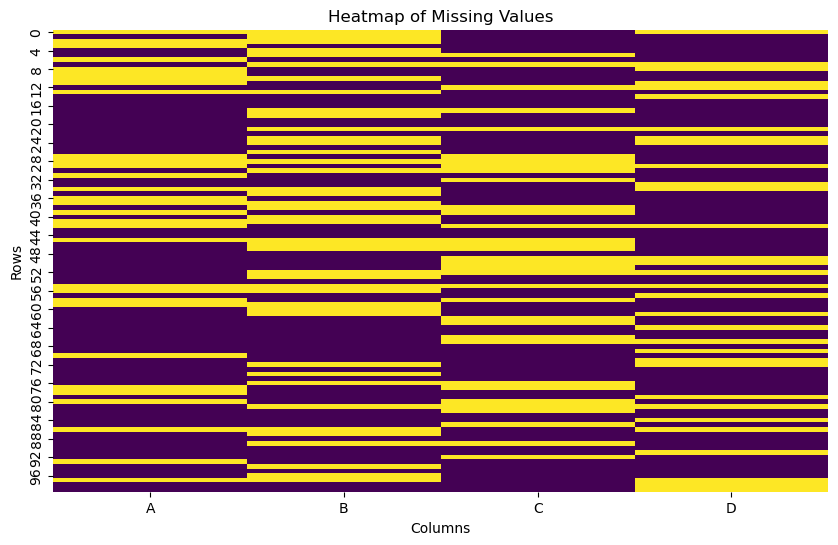

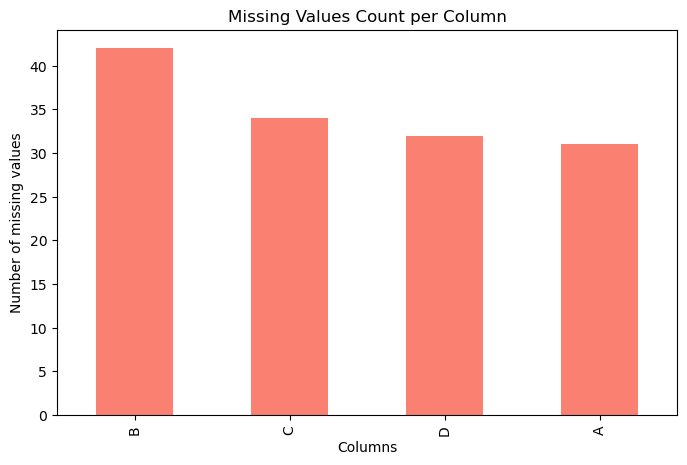

In [12]:
# show me some graphs to analyze NaN values

import matplotlib.pyplot as plt
import seaborn as sns

# Example DataFrame with NaN values (replace this with your actual DataFrame)
# For demonstration, we're creating a DataFrame with some random missing values.
np.random.seed(42)
data = {
    'A': np.random.choice([1, 2, np.nan], size=100),
    'B': np.random.choice([3, 4, np.nan], size=100),
    'C': np.random.choice([5, 6, np.nan], size=100),
    'D': np.random.choice([7, 8, np.nan], size=100)
}
df = pd.DataFrame(data)

# -------------------------------
# Plot 1: Heatmap of Missing Values
# -------------------------------
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Heatmap of Missing Values")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

# -------------------------------
# Plot 2: Bar Chart of Missing Values per Column
# -------------------------------
missing_counts = df.isnull().sum().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
missing_counts.plot(kind="bar", color='salmon')
plt.ylabel("Number of missing values")
plt.xlabel("Columns")
plt.title("Missing Values Count per Column")
plt.show()

In [13]:
all_props_df.fillna(0, inplace=True)


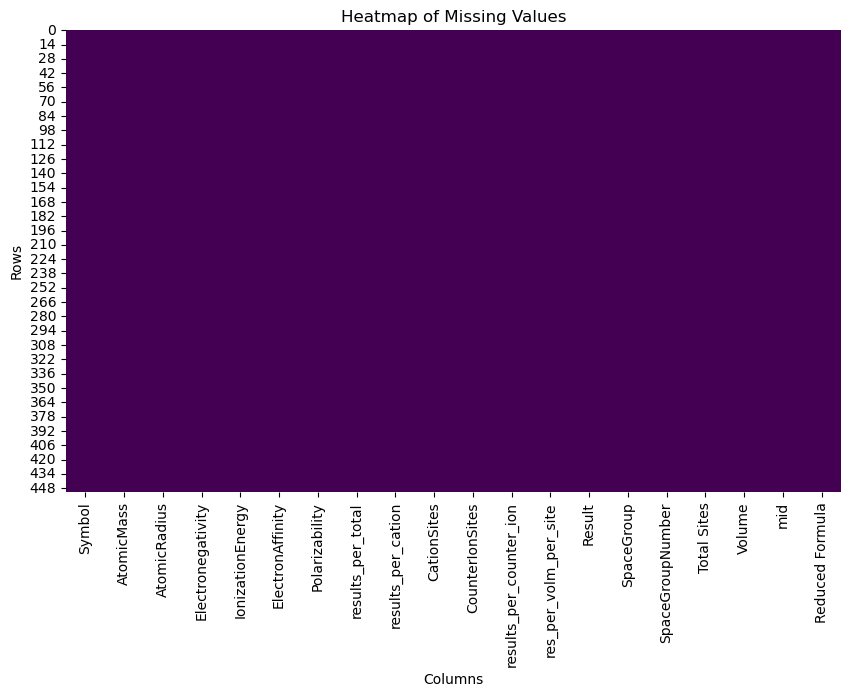

In [14]:
plt.figure(figsize=(10, 6))
sns.heatmap(all_props_df.isnull(), cbar=False, cmap="viridis")
plt.title("Heatmap of Missing Values")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

In [15]:
# all_props_df.to_csv('all_props_new.csv', index=False)
all_props_df = pd.read_csv('all_props.csv')

all_props_df

,Symbol,AtomicMass,AtomicRadius,Electronegativity,IonizationEnergy,ElectronAffinity,Polarizability,results_per_total,results_per_li,LiSites,CounterIonSites,results_per_counter_ion,res_per_volm_per_site,Result,SpaceGroup,SpaceGroupNumber,Total Sites,Reduced Formula
0,Ga,69.72300,187.0,1.81,5.999,0.300,50.00,9.796941,39.187765,0.250000,0.750000,0.013063,0.000608,0.608015,I4/mmm,139,4,LiGa3
1,Cu,63.55000,140.0,1.90,7.726,1.228,46.50,11.480842,45.923370,0.250000,0.750000,0.015308,0.000992,0.992138,P6_3/mmc,194,8,LiCu3
2,Ag,107.86800,172.0,1.93,7.576,1.302,55.00,9.966383,19.932766,0.500000,0.500000,0.019933,0.000655,0.654576,Pm-3m,221,2,LiAg
3,Pd,106.42000,202.0,2.20,8.337,0.557,26.14,14.731718,19.642290,0.750000,0.250000,0.058927,0.001023,1.023165,Fm-3m,225,4,Li3Pd
4,In,114.81800,193.0,1.78,5.786,0.300,65.00,16.166999,21.555999,0.750000,0.250000,0.064668,0.000883,0.883190,I4/mmm,139,4,Li3In
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,Tl,204.38300,196.0,1.62,6.108,0.200,66.00,8.369031,33.476125,0.250000,0.750000,0.011159,0.000323,0.322878,Pm-3m,221,4,LiTl3
448,Pm,144.91276,236.0,0.00,5.550,0.000,200.00,28.418258,113.673031,0.250000,0.750000,0.037891,0.000910,0.909962,Pm-3m,221,4,LiPm3
449,Mg,24.30500,173.0,1.31,7.646,0.000,71.20,7.544980,1131.746998,0.006667,0.993333,0.007596,0.000337,0.337076,P-6m2,187,150,LiMg149
450,Pt,195.08000,209.0,2.28,9.000,2.128,48.00,13.148270,17.531027,0.750000,0.250000,0.052593,0.000936,0.936110,I4/mmm,139,4,Li3Pt
